##  数据集

共有150组数据，每组包括花萼长、宽、花瓣长、宽的4个输入特征。同时给出，这一组特征对应的鸢尾花类别（分别是：狗尾草鸢尾、杂色鸢尾、弗吉尼亚鸢尾，分别用0，1，2表示）

In [6]:
from sklearn import datasets
from pandas import DataFrame
import pandas as pd

x_data = datasets.load_iris().data
y_data = datasets.load_iris().target

print(x_data[:5])
print(y_data[:5])

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
[0 0 0 0 0]


In [7]:
x_data = DataFrame(x_data, columns=['花萼长','宽','花瓣长','宽'])
pd.set_option('display.unicode.east_asian_width', True)
print(x_data)

     花萼长   宽  花瓣长   宽
0       5.1  3.5     1.4  0.2
1       4.9  3.0     1.4  0.2
2       4.7  3.2     1.3  0.2
3       4.6  3.1     1.5  0.2
4       5.0  3.6     1.4  0.2
..      ...  ...     ...  ...
145     6.7  3.0     5.2  2.3
146     6.3  2.5     5.0  1.9
147     6.5  3.0     5.2  2.0
148     6.2  3.4     5.4  2.3
149     5.9  3.0     5.1  1.8

[150 rows x 4 columns]


In [8]:
x_data['类别'] = y_data
print(x_data)

     花萼长   宽  花瓣长   宽  类别
0       5.1  3.5     1.4  0.2     0
1       4.9  3.0     1.4  0.2     0
2       4.7  3.2     1.3  0.2     0
3       4.6  3.1     1.5  0.2     0
4       5.0  3.6     1.4  0.2     0
..      ...  ...     ...  ...   ...
145     6.7  3.0     5.2  2.3     2
146     6.3  2.5     5.0  1.9     2
147     6.5  3.0     5.2  2.0     2
148     6.2  3.4     5.4  2.3     2
149     5.9  3.0     5.1  1.8     2

[150 rows x 5 columns]


## 准备数据
从sklearn中读取数据

### 数据读入

In [9]:
x_data = datasets.load_iris().data
y_data = datasets.load_iris().target

### 数据乱序

In [12]:
import numpy as np
import tensorflow as tf

np.random.seed(116)
np.random.shuffle(x_data)
np.random.seed(116)
np.random.shuffle(y_data)
tf.random.set_seed(116)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


### 生成训练集和测试集

In [17]:
x_train = x_data[:-30]
y_train = y_data[:-30]

x_test = x_data[-30:]
y_test = y_data[-30:]

x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)

### 特征和标签配对，每次读入一小股

In [18]:
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

## 搭建网络

In [19]:
#定义神经网络中所有可训练参数，定义了一层网络
w1 = tf.Variable(tf.random.truncated_normal([4,3], stddev=0.1, seed=1))
b1 = tf.Variable(tf.random.truncated_normal([3], stddev=0.1, seed=1))

In [20]:
import matplotlib.pyplot as plt

lr = 0.1 #学习率为0.1
train_loss_results = [] #每轮loss记录在这里
test_acc = [] #每轮acc记录在这里
epoch = 500 #训练500轮
loss_all = 0 #每轮分4个step，loss_all记录4个step生成的loss和

#训练
for epoch in range(epoch): #数据集级别迭代
    for step,(x_train, y_train) in enumerate(train_db): #batch级别迭代
        with tf.GradientTape() as tape:
            y = tf.matmul(x_train, w1) + b1
            y = tf.nn.softmax(y)
            y_ = tf.one_hot(y_train, depth=3)
            loss = tf.reduce_mean(tf.square(y_ - y)) #误差为y_ ,y的均方误差
            loss_all += loss.numpy() #将每个step中的 loss求和
        grads = tape.gradient(loss,[w1,b1])
        w1.assign_sub(lr*grads[0])
        b1.assign_sub(lr*grads[1])
    print('Epoch {}, loss: {}'.format(epoch, loss_all/4))
    train_loss_results.append(loss_all/4)
    loss_all = 0.

    #测试
    # total_correct为预测对的样本个数，total_number为总样本数
    total_correct, total_number = 0, 0
    for x_test, y_test in test_db:
        y = tf.matmul(x_test, w1) + b1
        y = tf.nn.softmax(y)
        pred = tf.argmax(y, axis=1) #返回y中最大值的索引，也就是预测到的分类
        #将pred转换为y_test的数据类型
        pred = tf.cast(pred, dtype=y_test.dtype)
        #若分类正确，则correct=1，否则为0
        correct = tf.cast(tf.equal(pred, y_test), dtype=tf.int32)
        #将每个batch的correct叠加
        correct = tf.reduce_sum(correct)
        #将所有batch中的correct相加
        total_correct += int(correct)
        #增加样本总数，也就是x_test的行数
        total_number += x_test.shape[0]
    #总的准确率等于total_correct/total_number
    acc = total_correct / total_number
    test_acc.append(acc)
    print('Test acc:', acc)
    print('-----------------')

Epoch 0, loss: 0.24537357687950134
Test acc: 0.6
-----------------
Epoch 1, loss: 0.21558940783143044
Test acc: 0.7
-----------------
Epoch 2, loss: 0.20025142654776573
Test acc: 0.7
-----------------
Epoch 3, loss: 0.18961529433727264
Test acc: 0.7
-----------------
Epoch 4, loss: 0.18059533089399338
Test acc: 0.7333333333333333
-----------------
Epoch 5, loss: 0.17276301607489586
Test acc: 0.8333333333333334
-----------------
Epoch 6, loss: 0.16600830480456352
Test acc: 0.8333333333333334
-----------------
Epoch 7, loss: 0.16019588708877563
Test acc: 0.8666666666666667
-----------------
Epoch 8, loss: 0.1551796793937683
Test acc: 0.9
-----------------
Epoch 9, loss: 0.15082340314984322
Test acc: 0.9333333333333333
-----------------
Epoch 10, loss: 0.14700951054692268
Test acc: 0.9333333333333333
-----------------
Epoch 11, loss: 0.14364051446318626
Test acc: 0.9333333333333333
-----------------
Epoch 12, loss: 0.14063729345798492
Test acc: 0.9333333333333333
-----------------
Epoch 1

Epoch 104, loss: 0.06828150991350412
Test acc: 0.9333333333333333
-----------------
Epoch 105, loss: 0.06793585326522589
Test acc: 0.9333333333333333
-----------------
Epoch 106, loss: 0.06759410630911589
Test acc: 0.9333333333333333
-----------------
Epoch 107, loss: 0.06725622247904539
Test acc: 0.9333333333333333
-----------------
Epoch 108, loss: 0.06692214217036963
Test acc: 0.9333333333333333
-----------------
Epoch 109, loss: 0.06659179832786322
Test acc: 0.9333333333333333
-----------------
Epoch 110, loss: 0.06626515556126833
Test acc: 0.9333333333333333
-----------------
Epoch 111, loss: 0.065942139364779
Test acc: 0.9333333333333333
-----------------
Epoch 112, loss: 0.06562270037829876
Test acc: 0.9333333333333333
-----------------
Epoch 113, loss: 0.06530678831040859
Test acc: 0.9333333333333333
-----------------
Epoch 114, loss: 0.06499436497688293
Test acc: 0.9333333333333333
-----------------
Epoch 115, loss: 0.06468534376472235
Test acc: 0.9333333333333333
------------

Epoch 206, loss: 0.04624398238956928
Test acc: 0.9333333333333333
-----------------
Epoch 207, loss: 0.04611236695200205
Test acc: 0.9333333333333333
-----------------
Epoch 208, loss: 0.045981778763234615
Test acc: 0.9333333333333333
-----------------
Epoch 209, loss: 0.045852203853428364
Test acc: 0.9333333333333333
-----------------
Epoch 210, loss: 0.04572361707687378
Test acc: 0.9333333333333333
-----------------
Epoch 211, loss: 0.04559602960944176
Test acc: 0.9333333333333333
-----------------
Epoch 212, loss: 0.04546940140426159
Test acc: 0.9333333333333333
-----------------
Epoch 213, loss: 0.04534374549984932
Test acc: 0.9333333333333333
-----------------
Epoch 214, loss: 0.04521904233843088
Test acc: 0.9333333333333333
-----------------
Epoch 215, loss: 0.04509528260678053
Test acc: 0.9333333333333333
-----------------
Epoch 216, loss: 0.044972460716962814
Test acc: 0.9333333333333333
-----------------
Epoch 217, loss: 0.044850556179881096
Test acc: 0.9333333333333333
------

Epoch 313, loss: 0.03629914624616504
Test acc: 0.9333333333333333
-----------------
Epoch 314, loss: 0.03623408870771527
Test acc: 0.9333333333333333
-----------------
Epoch 315, loss: 0.03616939811035991
Test acc: 0.9333333333333333
-----------------
Epoch 316, loss: 0.03610505489632487
Test acc: 0.9333333333333333
-----------------
Epoch 317, loss: 0.03604108327999711
Test acc: 0.9333333333333333
-----------------
Epoch 318, loss: 0.03597744973376393
Test acc: 0.9333333333333333
-----------------
Epoch 319, loss: 0.03591416822746396
Test acc: 0.9333333333333333
-----------------
Epoch 320, loss: 0.035851242020726204
Test acc: 0.9333333333333333
-----------------
Epoch 321, loss: 0.03578865388408303
Test acc: 0.9333333333333333
-----------------
Epoch 322, loss: 0.035726410802453756
Test acc: 0.9333333333333333
-----------------
Epoch 323, loss: 0.03566450206562877
Test acc: 0.9333333333333333
-----------------
Epoch 324, loss: 0.03560293233022094
Test acc: 0.9333333333333333
--------

Epoch 416, loss: 0.03108135797083378
Test acc: 0.9333333333333333
-----------------
Epoch 417, loss: 0.031042088754475117
Test acc: 0.9333333333333333
-----------------
Epoch 418, loss: 0.03100299136713147
Test acc: 0.9333333333333333
-----------------
Epoch 419, loss: 0.03096406441181898
Test acc: 0.9333333333333333
-----------------
Epoch 420, loss: 0.030925301369279623
Test acc: 0.9333333333333333
-----------------
Epoch 421, loss: 0.030886703170835972
Test acc: 0.9333333333333333
-----------------
Epoch 422, loss: 0.0308482781983912
Test acc: 0.9333333333333333
-----------------
Epoch 423, loss: 0.0308100045658648
Test acc: 0.9333333333333333
-----------------
Epoch 424, loss: 0.030771898105740547
Test acc: 0.9333333333333333
-----------------
Epoch 425, loss: 0.03073396161198616
Test acc: 0.9333333333333333
-----------------
Epoch 426, loss: 0.030696174595505
Test acc: 0.9333333333333333
-----------------
Epoch 427, loss: 0.030658543575555086
Test acc: 0.9333333333333333
---------

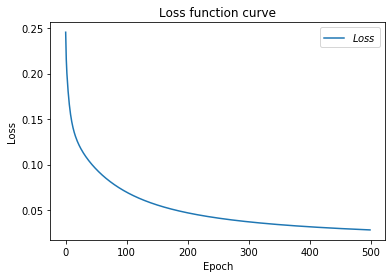

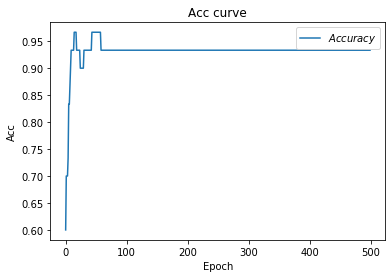

In [21]:
#绘制loss曲线
plt.title('Loss function curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_loss_results, label='$Loss$')
plt.legend()
plt.show()

#绘制accuracy曲线
plt.title('Acc curve')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.plot(test_acc, label='$Accuracy$')
plt.legend()
plt.show()